**1**. 15 points

The MNIST data set needs to be downloaded from https://pjreddie.com/media/files/mnist_train.csv and https://pjreddie.com/media/files/mnist_test.csv and put in the data sub-directory first.

- Load the training and test MNIST digits data sets from `data/mnist_train.csv` and `data/mnist_test.csv`, and split into labels (column 0) and features (all other columns). 
- Each row is a vector of length 784 with values between 0 (black) and 255 (white) on the gray color scale. 
- Display the 3rd vector in the training set as a $28 \times 28$ image using `matplotlib`, using a helper function that plots an image and its corresponding label in the title given its row number, the feature matrix and the label vector.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%%bash

wget -O data/mnist_train.csv https://pjreddie.com/media/files/mnist_train.csv -q
wget -O data/mnist_test.csv https://pjreddie.com/media/files/mnist_test.csv -q

Read the data in:

In [3]:
train_data = pd.read_csv("data/mnist_train.csv", header = None)
test_data = pd.read_csv("data/mnist_test.csv", header = None)

Split data into features and labels:

In [4]:
train_data_label = train_data[0].to_frame()
test_data_label = test_data[0].to_frame()

train = train_data.iloc[:, 1:]
test = test_data.iloc[:, 1:]

In [5]:
def plot_vector(data, labels, row_number):
    # plot_vector takes a dataframe, uses the first column as the labels and the other columns
    # as feature points. It interprets the data as greyscale color values and plots them using matplotlib
    # Must specify the row_number to plot
    # Note: plot_vector assumes data has vector lengths of 784 such that
    # the vectors can be reshaped to 28 x 28 matrices
    # Also: row_number assumes indexing begins with 0 such that the 3rd vector would have index 2
    
    plt.title("Label: " + str(labels.loc[row_number][0]));
    plt.imshow(data.loc[row_number].values.reshape(28,28));
    

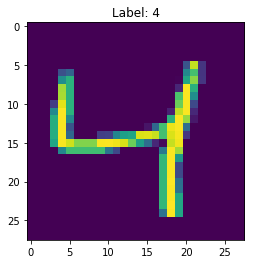

In [6]:
plot_vector(data = train, labels = train_data_label, row_number = 2)

**2**. 20 points

- Use PCA to reduce the number of dimensions of the training data set so that it includes just above 90% of the total variance. Remember to scale the data before doing PCA.
- How many components are used?
- Reconstruct the training set from the dimension-reduced one. Do this without using the `inverse_transform` method (you can use this to check your solution)
- Show the image of the reconstructed data set for the vector in the third row.

In [7]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

From the sklearn.decomposition.PCA documentation:

If 0 < n_components < 1 and svd_solver == 'full', select the number of components such that the amount of variance that needs to be explained is greater than the percentage specified by n_components.

Scale and then fit_transform the training set

In [8]:
scaler = preprocessing.StandardScaler().fit_transform(train)
pca = PCA(n_components = 0.9, svd_solver = 'full')
z = pca.fit_transform(scaler)

In [9]:
pca.explained_variance_ratio_.shape

(236,)

There are 236 components needed to explain 90% of the total variance.

In [10]:
recovered_train = np.dot(z,pca.components_)

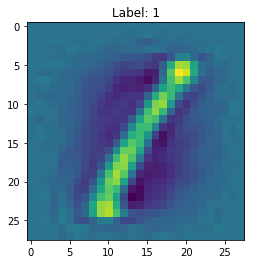

In [11]:
plot_vector(data = pd.DataFrame(recovered_train), labels = train_data_label, row_number = 3)

**3**. 15 points
 
- Using the test dataset, first use PCA to reduce the dimensionality from 784 to 50. Remember to scale the data before doing PCA.
- Now use TSNE to further reduce the 50 dimensional data set to 2. 
- Plot a scatter plot of the data, coloring each point by its label. 
- Create a legend for the plot showing what color points go with what label

(Note: The TSNE transform will take a few minutes - go have coffee.)

In [12]:
from sklearn.manifold import TSNE

In [13]:
scaler = preprocessing.StandardScaler().fit_transform(test)
pca = PCA(n_components = 50)
z = pca.fit_transform(scaler)

In [14]:
tsne = TSNE(n_components = 2)
z = tsne.fit_transform(z)

In [15]:
nc = len(test_data_label.squeeze().unique()) # Number of unique labels = number of actual clusters

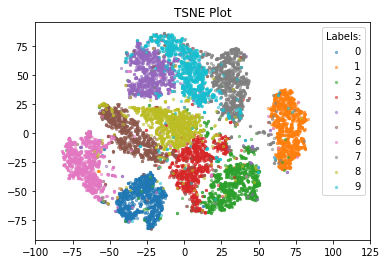

In [16]:
for i in range(10):
    idx = (np.array(test_data_label) == i).flatten()
    plt.scatter(x = z[idx, 0], y = z[idx, 1], label = i, s = 5,
               cmap = plt.cm.get_cmap('Accent', nc),
               alpha = 0.5);
    plt.legend(loc = 'upper right', title = "Labels:")
plt.xlim(-100, 125)
plt.title("TSNE Plot")
plt.show();

**4**. 50 points

- Implement the k-means++ algorithm from the description given at https://en.wikipedia.org/wiki/K-means%2B%2B (summarized below)
- Use k-means++ to initialize a k-means clustering of the TsNE 2-dimensional data, using your own code (i.e. do not use `scikit-learn` or similar libraries for this)
- Align the true labels and the k-means labels and show the two TSNE plots side-by-side with coloring of points by label values

K-means++ algorithm to initialize centers

- Choose one center uniformly at random from among the data points.
- For each data point x, compute D(x), the distance between x and the nearest center that has already been chosen.
- Choose one new data point at random as a new center, using a weighted probability distribution where a point x is chosen with probability proportional to D(x)2.
- Repeat Steps 2 and 3 until k centers have been chosen.
- Now that the initial centers have been chosen, proceed using standard k-means clustering.

In [17]:
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

In [18]:
def closest_center(X, centers):
    """closest center takes a n x 2 matrix of data and a list of center points
       and calculates the mean distance from every point to each center, then 
       returns the center that has the least distance"""
    
    smallest_mean = np.infty
    smallest_index = 0
    for i, c in enumerate(centers):
        temp = np.mean(cdist(X, c.reshape(1, 2)), axis = 0)
        if(temp < smallest_mean):
            smallest_mean = temp
            smallest_index = i
    return(centers[smallest_index])

In [19]:
def add_center(X, centers):
    """add_center takes a n x 2 matrix of data and a list of center points
       and calculates a weighted probability vector using the distance to the nearest center as weights
       Returns a random point selected from the data matrix conditioned on probability matrix"""
    
    r, c = X.shape
    probability_vector = cdist(X, closest_center(X, centers).reshape(1, 2))**2
    
    return(X[np.random.choice(r, 1, replace = False, p = (probability_vector / probability_vector.sum()).flatten())])

In [20]:
def generate_centers(X, k):
    """generate_centers takes a n x 2 matrix of data and a desired number of centers k
       such that it will generate k centers based on a weighted probability vector which
       is based on the distance from the data points to the nearest center"""
    
    r, c = X.shape
    centers = X[np.random.choice(r, 1, replace = False)] # initialize our list of centers with a single point
    
    for j in range(1, k):
        centers = np.append(centers, add_center(X, centers), axis = 0)
    
    return(centers)

In [21]:
def my_kmeans(X, k, tol=1e-6, n_starts=10):
    """K-means with tolerance and random restarts."""
    
    r, c = X.shape
    best_score = np.infty
  
    for i in range(n_starts):
        centers = generate_centers(X, k) # Call our k-means++ function
        delta = np.infty
        while delta > tol:
            m = cdist(X, centers)
            z = np.argmin(m, axis=1)
            new_centers = np.array([np.mean(X[z==i], axis=0) for i in range(k)])
            delta = np.sum((new_centers - centers)**2)
            centers = new_centers
        score = m[z].sum()
        if score < best_score:
            best_score = score
            best_z = z
            best_centers = centers
    return (best_z, best_centers)

In [22]:
np.random.seed(2018)
points, centers = my_kmeans(z, nc)

In [23]:
# Create centers of TSNE plot for purpose of alignment
centers2 = []
for i in range(10):
    idx = (np.array(test_data_label) == i).flatten()
    centers2.append(np.mean(z[idx, :], axis = 0))

centers2 = np.asarray(centers2)
row_ind, col_ind = linear_sum_assignment(cdist(centers, centers2))

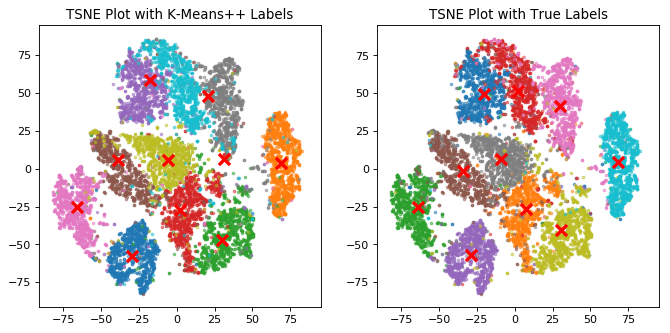

In [27]:
plt.figure(num = None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.tight_layout()

# First Plot
plt.subplot(1, 2, 1)
for i in row_ind:
    idx = (np.array(test_data_label) == i).flatten()
    plt.scatter(z[idx, 0], z[idx, 1], s = 5, #c = points[idx],
                cmap = plt.cm.get_cmap('Accent', nc),
                alpha = 0.5);
plt.scatter(centers[:, 0], centers[:, 1], marker='x', 
            linewidth = 3, s = 100, c = 'red');
plt.title("TSNE Plot with K-Means++ Labels")
plt.axis('square');

# Second Plot
plt.subplot(1, 2, 2)
for i in col_ind:
    idx = (np.array(test_data_label) == i).flatten()
    plt.scatter(z[idx, 0], z[idx, 1], s = 5, #c = points[idx],
               cmap = plt.cm.get_cmap('Accent', nc),
               alpha = 0.5);
plt.scatter(centers2[:, 0], centers2[:, 1], marker = 'x',
            linewidth = 3, s = 100, c = 'red');
plt.title("TSNE Plot with True Labels");
plt.axis('square');

plt.show();